In [2]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
from scipy.special import erf
import h5py
import os
from unyt import angstrom, Msun, yr, m, erg, s, Hz

from synthesizer.grid import Grid
from synthesizer import Sed

import swiftascmaps
import cmasher as cmr


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

def get_n_colors_from_cmap(n, cmap_name="viridis"):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 0.9, n)]
    return colors

In [34]:
subvolumes = ["0_0_0"]  # keep only the ones you want

pipeline_dir = '/mnt/home/snewman/ceph/pipeline_results/combined'
pipeline_name = 'pipeline_nodust_mdotcut_subradio'

wavelengths = np.logspace(0.1, 6, 100000) * angstrom

def get_lf(pipeline_name, wavelength1, wavelength2):

    # From the .hdf5 get the spectra

    FUV_slope = np.concatenate([
        h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}.hdf5'), 'r')['Galaxies/LHC_FUV_slope'][:]
        for subvol in subvolumes
    ])

    print('FUV slope:', FUV_slope)

    grp_total = 'Galaxies/Spectra/SpectralLuminosityDensities/total'
    spectra = np.concatenate([
        h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}.hdf5'), 'r')[f'{grp_total}'][:]
        for subvol in subvolumes
    ])
    print(f'Gathered spectra for {pipeline_name} and {spectra.shape} galaxies')

    # And get the B band luminosity for each galaxy

    sed = Sed(wavelengths, spectra * erg / (s * Hz))
    band_window_limits = (wavelength1 * angstrom, wavelength2 * angstrom)
    band_lum = sed.measure_window_luminosity(band_window_limits)
    log_band_lum = np.log10(band_lum)

    print(f'Calculated B luminosities for {pipeline_name} and {spectra.shape} galaxies')

    # Define the volume for CAMELS-SAM

    BOX_SIZE = 150.0 # Mpc
    VOLUME = BOX_SIZE**3 / 8

    # Define our bins and calculate the LF

    DEX_WIDTH = 0.5
    bins = np.arange(np.floor(log_band_lum.min()), np.ceil(log_band_lum.max()) + DEX_WIDTH, DEX_WIDTH)
    hist, edges = np.histogram(log_band_lum, bins=bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    phi = hist / (VOLUME * DEX_WIDTH)
    sigma_phi = np.sqrt(hist) / (VOLUME * DEX_WIDTH)

    print(f'Calculated LFs for {pipeline_name} and {spectra.shape} galaxies for {wavelength1}-{wavelength2} Angstrom')

    return spectra, bin_centers, phi, sigma_phi

In [6]:
def plot_lf(bin_centers, phi, sigma_phi, plot_label, line_color):

    # For plotting, avoid zeros when using log
    positive = phi > 0

    # Plot the LF
    plt.plot(bin_centers[positive], phi[positive], color=line_color, lw=3, label=plot_label)

    # Add poisson error shading
    plt.fill_between(bin_centers[positive],
                    phi[positive] - sigma_phi[positive],
                    phi[positive] + sigma_phi[positive],
                    color="gray", alpha=0.3)
    
    plt.xlim(42, 45)


In [31]:
bin_centers, phi, sigma_phi = get_lf(pipeline_name='pipeline_nodust_mdotcut_subradio')

bin_centers2, phi2, sigma_phi2 = get_lf(pipeline_name='pipeline_fixed_li08')

Gathered spectra for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
[Python] Creating Sed took: 0.001757 seconds
Calculated B luminosities for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
Calculated LFs for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
Gathered spectra for pipeline_fixed_li08 and (5630, 100000) galaxies
[Python] Creating Sed took: 0.002015 seconds
Calculated B luminosities for pipeline_fixed_li08 and (5630, 100000) galaxies
Calculated LFs for pipeline_fixed_li08 and (5630, 100000) galaxies


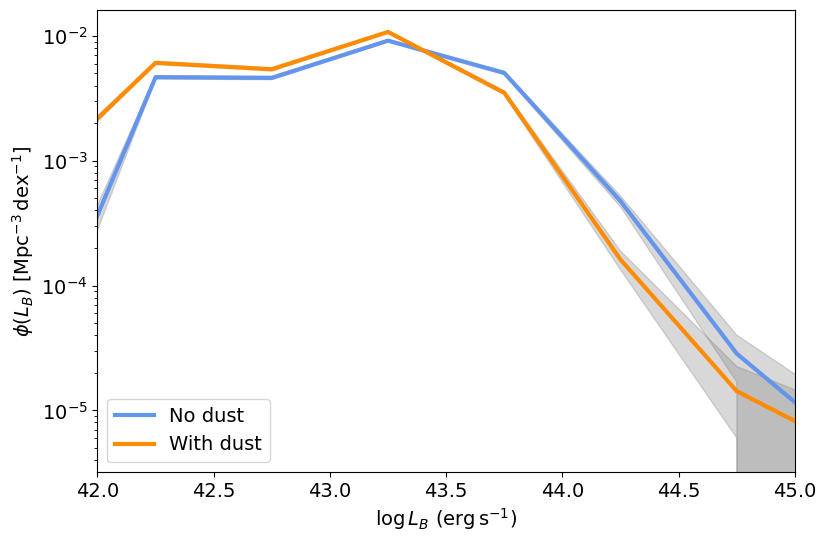

In [37]:
plt.figure(figsize=(9, 6))
plot_lf(bin_centers, phi, sigma_phi, plot_label='No dust', line_color='cornflowerblue')
plot_lf(bin_centers2, phi2, sigma_phi2, plot_label='With dust', line_color='darkorange')

plt.yscale('log')
plt.xlabel(r'$\log L_B\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_B)\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(loc='lower left')

In [14]:
# Get LFs for the different dust LHC parameter combinations

spectra0, bin_centers0, phi0, sigma_phi0 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex0')
spectra1, bin_centers1, phi1, sigma_phi1 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex1')
#bin_centers2, phi2, sigma_phi2 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex2')
#bin_centers3, phi3, sigma_phi3 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex3')
#bin_centers4, phi4, sigma_phi4 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex4')

FUV slope: [3.735627 3.735627 3.735627 ... 3.735627 3.735627 3.735627]
Gathered spectra for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
Calculated B luminosities for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
Calculated LFs for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
FUV slope: [1.393718 1.393718 1.393718 ... 1.393718 1.393718 1.393718]
Gathered spectra for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies
Calculated B luminosities for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies
Calculated LFs for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies


[0.00000000e+00 8.01185185e-04 6.09185185e-03 5.43762963e-03
 1.06951111e-02 3.48444444e-03 1.61185185e-04 1.42222222e-05
 4.74074074e-06 0.00000000e+00]
[0.00000000e+00 9.57629630e-04 5.96859259e-03 5.50400000e-03
 1.06714074e-02 3.40859259e-03 1.61185185e-04 1.42222222e-05
 4.74074074e-06 0.00000000e+00]


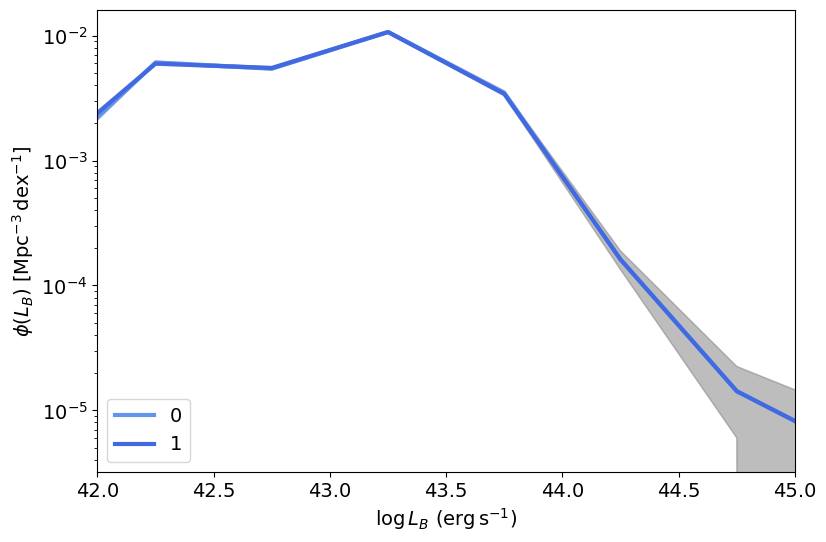

In [15]:
plt.figure(figsize=(9, 6))
plot_lf(bin_centers0, phi0, sigma_phi0, plot_label='0', line_color='cornflowerblue')
plot_lf(bin_centers1, phi1, sigma_phi1, plot_label='1', line_color='royalblue')
#plot_lf(bin_centers2, phi2, sigma_phi2, plot_label='2', line_color='seagreen')
#plot_lf(bin_centers3, phi3, sigma_phi3, plot_label='3', line_color='darkorange')
#plot_lf(bin_centers4, phi4, sigma_phi4, plot_label='4', line_color='crimson')

print(phi0)
print(phi1)

plt.yscale('log')
plt.xlabel(r'$\log L_B\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_B)\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(loc='lower left')

(5630, 100000)


/tmp/ipykernel_2521467/414828154.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu0), lw=2, label='0')
/tmp/ipykernel_2521467/414828154.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu1), lw=2, label='1')


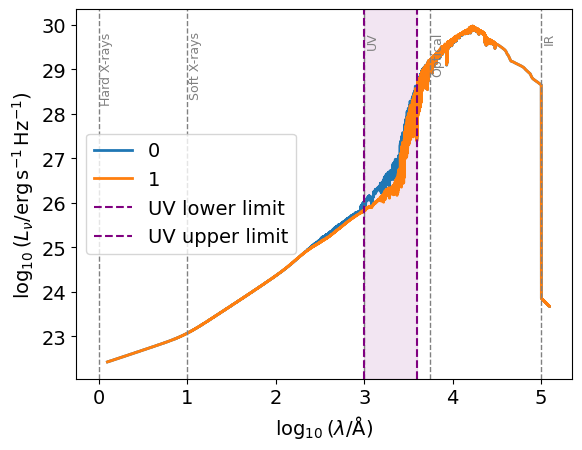

In [33]:
print(spectra1.shape)

lnu0 = spectra0[0, :]
lnu1 = spectra1[0, :]
lams = np.logspace(0.1, 6, 100000) 

plt.plot(np.log10(lams), np.log10(lnu0), lw=2, label='0')
plt.plot(np.log10(lams), np.log10(lnu1), lw=2, label='1')

# Add reference wavelength bands
bands = {
    'Hard X-rays': 1,        # ~1 Å
    'Soft X-rays': 10,       # ~10 Å
    'UV': 1000,              # ~1000 Å
    'Optical': 5500,         # ~5500 Å
    'IR': 100000,            # ~1e5 Å (10 µm)
}

for label, lam in bands.items():
    plt.axvline(np.log10(lam), color='gray', ls='--', lw=1)
    plt.text(np.log10(lam) + 0.02, plt.ylim()[1] - 0.5, label,
             rotation=90, va='top', ha='left', fontsize=9, color='gray')

# --- Add UV wavelength range limits (approx. 1000–4000 Å) ---
uv_lower = 1000   # lower limit (far UV)
uv_upper = 4000   # upper limit (near UV)

plt.axvline(np.log10(uv_lower), color='purple', ls='--', lw=1.5, label='UV lower limit')
plt.axvline(np.log10(uv_upper), color='purple', ls='--', lw=1.5, label='UV upper limit')

# Optional: shaded region to highlight the UV range
plt.axvspan(np.log10(uv_lower), np.log10(uv_upper), color='purple', alpha=0.1)


plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
plt.legend()

In [42]:
wavelength1 = 1000
wavelength2 = 4000

spectra0, bin_centers0, phi0, sigma_phi0 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex0', wavelength1=wavelength1, wavelength2=wavelength2)
spectra1, bin_centers1, phi1, sigma_phi1 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex1', wavelength1=wavelength1, wavelength2=wavelength2)
spectra2, bin_centers2, phi2, sigma_phi2 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex2', wavelength1=wavelength1, wavelength2=wavelength2)
spectra3, bin_centers3, phi3, sigma_phi3 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex3', wavelength1=wavelength1, wavelength2=wavelength2)
spectra4, bin_centers4, phi4, sigma_phi4 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex4', wavelength1=wavelength1, wavelength2=wavelength2)

FUV slope: [3.735627 3.735627 3.735627 ... 3.735627 3.735627 3.735627]
Gathered spectra for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
Calculated B luminosities for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
Calculated LFs for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies for 1000-4000 Angstrom
FUV slope: [1.393718 1.393718 1.393718 ... 1.393718 1.393718 1.393718]
Gathered spectra for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies
Calculated B luminosities for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies
Calculated LFs for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies for 1000-4000 Angstrom
FUV slope: [0.060846 0.060846 0.060846 ... 0.060846 0.060846 0.060846]
Gathered spectra for pipeline_li08_0_0_0_lhcindex2 and (5630, 100000) galaxies
Calculated B luminosities for pipeline_li08_0_0_0_lhcindex2 and (5630, 100000) galaxies
Calculated LFs for pipeline_li08_0_0_0_lhcindex2 and (5630, 100000) galaxies for 1000-

(5630, 100000)


/tmp/ipykernel_2521467/2372078835.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu0), lw=2, label='0', color='cornflowerblue')
/tmp/ipykernel_2521467/2372078835.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu1), lw=2, label='1', color='royalblue')
/tmp/ipykernel_2521467/2372078835.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu2), lw=2, label='2', color='seagreen')
/tmp/ipykernel_2521467/2372078835.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu3), lw=2, label='3', color='darkorange')
/tmp/ipykernel_2521467/2372078835.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu4), lw=2, label='4', color='crimson')


Text(0, 0.5, '$\\log_{10}(L_\\nu/\\rm{erg\\,s^{-1}\\,Hz^{-1}})$')

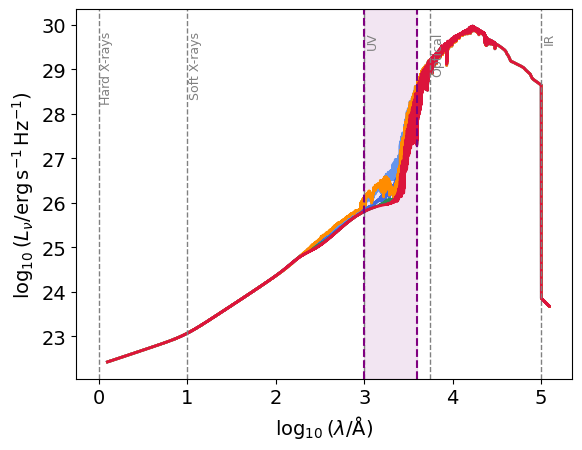

In [49]:
print(spectra1.shape)

lnu0 = spectra0[0, :]
lnu1 = spectra1[0, :]
lnu2 = spectra2[0, :]
lnu3 = spectra3[0, :]
lnu4 = spectra4[0, :]
lams = np.logspace(0.1, 6, 100000) 

plt.plot(np.log10(lams), np.log10(lnu0), lw=2, label='0', color='cornflowerblue')
plt.plot(np.log10(lams), np.log10(lnu1), lw=2, label='1', color='royalblue')
plt.plot(np.log10(lams), np.log10(lnu2), lw=2, label='2', color='seagreen')
plt.plot(np.log10(lams), np.log10(lnu3), lw=2, label='3', color='darkorange')
plt.plot(np.log10(lams), np.log10(lnu4), lw=2, label='4', color='crimson')

# Add reference wavelength bands
bands = {
    'Hard X-rays': 1,        # ~1 Å
    'Soft X-rays': 10,       # ~10 Å
    'UV': 1000,              # ~1000 Å
    'Optical': 5500,         # ~5500 Å
    'IR': 100000,            # ~1e5 Å (10 µm)
}

for label, lam in bands.items():
    plt.axvline(np.log10(lam), color='gray', ls='--', lw=1)
    plt.text(np.log10(lam) + 0.02, plt.ylim()[1] - 0.5, label,
             rotation=90, va='top', ha='left', fontsize=9, color='gray')

# --- Add UV wavelength range limits (approx. 1000–4000 Å) ---
uv_lower = 1000   # lower limit (far UV)
uv_upper = 4000   # upper limit (near UV)

plt.axvline(np.log10(uv_lower), color='purple', ls='--', lw=1.5, label='UV lower limit')
plt.axvline(np.log10(uv_upper), color='purple', ls='--', lw=1.5, label='UV upper limit')

# Optional: shaded region to highlight the UV range
plt.axvspan(np.log10(uv_lower), np.log10(uv_upper), color='purple', alpha=0.1)


plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")

[9.33925926e-04 4.29985185e-03 1.33783704e-02 5.90222222e-03
 1.22785185e-03 4.83555556e-04 2.74962963e-04 1.37481481e-04
 4.26666667e-05 9.48148148e-06]
[1.82992593e-03 4.49896296e-03 1.39520000e-02 4.38518519e-03
 1.09037037e-03 4.69333333e-04 2.74962963e-04 1.37481481e-04
 4.26666667e-05 9.48148148e-06]


(0.0001, np.float64(0.02177801384350449))

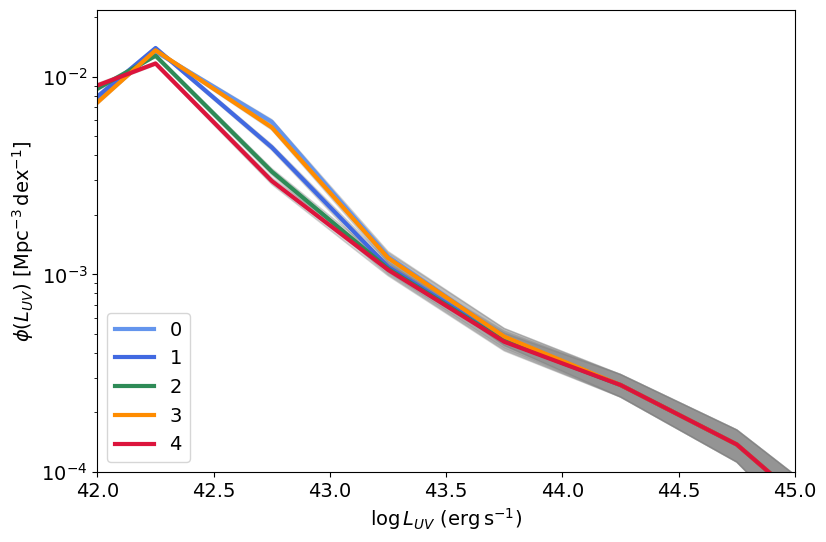

In [50]:
plt.figure(figsize=(9, 6))
plot_lf(bin_centers0, phi0, sigma_phi0, plot_label='0', line_color='cornflowerblue')
plot_lf(bin_centers1, phi1, sigma_phi1, plot_label='1', line_color='royalblue')
plot_lf(bin_centers2, phi2, sigma_phi2, plot_label='2', line_color='seagreen')
plot_lf(bin_centers3, phi3, sigma_phi3, plot_label='3', line_color='darkorange')
plot_lf(bin_centers4, phi4, sigma_phi4, plot_label='4', line_color='crimson')

print(phi0)
print(phi1)

plt.yscale('log')
plt.xlabel(r'$\log L_{UV} \ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_{UV})\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(loc='lower left')
plt.ylim(bottom=1e-4)